<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/HMM_Inference__TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hidden Markov Model (HMM) State Inference
The **HMM_Inference** class includes the methods listed below which are capable of inferring from batched samples and are implemented from the book, [Probabilistic Machine Learning: Advanced Topics (Murphy K., 2023)](https://probml.github.io/pml-book/book2.html):


1.   Forward-Backwards algorithm
2.   The Viterbi algorithm


This notebook contains examples for HMM with Categorical and Gaussian emission distributions.

Any arbitrary emission distribution (Categorical, Normal, Poisson, etc.) is permitted as long as it contains a **log_prob** method (see [TensorFlow Probability Distributions](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Distribution)).

1. **Forward-Backwards Algorithm** <br><br>
Given the state transition matrix, emission distribution, and intial state probability vector: $\theta=(A, B, \pi)$, the filtering (Forwards) and smoothing (Backwards) operations are as follows:
\begin{align*}
\boldsymbol\alpha_t&= \Pr(\mathbf z_t|\mathbf y_{1}\cdots \mathbf y_{t}, \boldsymbol\theta)\\
&= \text{normalize}( B  \odot (A^\top \boldsymbol \alpha_{t-1}))\\ \\
\boldsymbol \gamma_t &=\Pr(\mathbf z_t|\mathbf y_{1}\cdots \mathbf y_{N}, \boldsymbol\theta)\\
&= \text{normalize}(\boldsymbol\alpha_t \odot \boldsymbol\beta_t)
\end{align*}
where
\begin{align*}
\boldsymbol\beta_{t-1}&=\Pr(\mathbf y_1\cdots \mathbf y_t|\mathbf z_t)\\
&= A( B_t \odot \boldsymbol\beta_t)
\end{align*}
The base case for the algorithms are:
\begin{align*}
\boldsymbol \alpha_1&=\boldsymbol \lambda_1 \odot \boldsymbol \pi\\
\boldsymbol\beta_N &= \boldsymbol 1
\end{align*}
The two-slice smoothed marginals are also computed as follows:
\begin{align*}
\boldsymbol \xi_{t, t+1} &= \Pr(\mathbf z_t, \mathbf z_{t+1}|\mathbf y_1\cdots \mathbf y_N)\\
&= \frac{A\odot [\boldsymbol \alpha_t(B_{t-1}\odot \boldsymbol \beta_{t-1})^\top]}{\Pr(\mathbf y_{t+1}\cdots \mathbf y_N|\mathbf y_1\cdots \mathbf y_{t})}
\end{align*}
Note that the denominator above is also the normalizing constant used in computing $\boldsymbol \alpha_t$.
<br><br>
2. **The Viterbi Algorithm** <br>




In [1]:
!pip install tqdm -q

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
from tqdm import tqdm

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

## HMM Inference Class

In [14]:
class HMM_Inference:
  def __init__(self, transition_matrix, emission_distribution, emission_params, states_0, observations):
    self.emission_model = emission_distribution(emission_params)
    self.local_evidence = tf.exp(self.emission_model.log_prob(observations[..., tf.newaxis]))[..., tf.newaxis]
    self.batch_dims = self.local_evidence.shape[0]
    self.num_steps = self.local_evidence.shape[1]
    self.transition_matrix = transition_matrix
    self.states_0 = states_0
    self.num_states = transition_matrix.shape[0]

  def normalizing_constant(self, x):
    return (tf.reduce_sum(x, -2, keepdims=True))

  def Forward(self):
    a_t = self.states_0 * self.local_evidence[:, 0]
    Z = self.normalizing_constant(a_t)
    a = a_t / Z
    for i in tqdm(range(1, self.num_steps)):
      a_t = self.local_evidence[:, i] * (tf.transpose(self.transition_matrix) @ a_t)
      Z_t = self.normalizing_constant(a_t)
      a_t = a_t / Z_t
      Z = tf.concat([Z, Z_t], 1)
      a = tf.concat([a, a_t], 2)
    return tf.transpose(a, [0, 2, 1])[..., tf.newaxis], Z

  def Backward(self, a, a_Z):
    β = β_t = tf.fill([self.batch_dims, self.num_states, 1], 1.)
    for i in tqdm(range(self.num_steps - 1, 0, -1)):
      β_t = self.transition_matrix @ (self.local_evidence[:, i] * β_t)
      β_t = β_t / a_Z[:, i][..., tf.newaxis]
      β = tf.concat([β, β_t], 2)    
    β = tf.reverse(β, [-1])
    β = tf.transpose(β, [0, 2, 1])[..., tf.newaxis]
    g = a * β
    g = g / self.normalizing_constant(g)
    return g, β

  def TwoSlice_Marginals(self, a, β):
    a = a[:, :-1]
    β = β[:, 1:]
    λ = self.local_evidence[:, 1:]
    ξ = self.transition_matrix * (a @ tf.transpose(λ * β, [0, 1, 3, 2]) )
    K = tf.reduce_sum(tf.reduce_sum(ξ, -1), -1, keepdims=True)
    ξ = ξ / tf.broadcast_to(K[..., tf.newaxis], ξ.shape)
    return ξ

  def Viterbi(self):
    δ_t = - tf.math.log(self.local_evidence[:, 0]) - tf.math.log(self.states_0)
    λ = - tf.math.log(tf.transpose(self.local_evidence, [0, 1, 3, 2]))
    λ = tf.tile(λ, [1, self.batch_dims, self.num_states, 1]) 
    A = - tf.math.log(tf.transpose(self.transition_matrix))
    for i in tqdm(range(1, self.num_steps)):
      δ_ = A + λ[:, i] + tf.tile(tf.transpose(δ_t, [0, 2, 1]), [1, self.num_states, 1])
      min_index = tf.math.argmin(δ_, 2)[..., tf.newaxis]
      δ_t = tf.gather_nd(δ_, min_index, 2)[..., tf.newaxis]
      if i == 1: 
        node = min_index
      else: 
        node = tf.concat([node, min_index], 2)
    node = tf.transpose(node, [0, 2, 1])
    state_t = tf.math.argmin(tf.reshape(δ_, [self.batch_dims, self.num_states * self.num_states]), 1)
    state_t = tf.cast(state_t/self.num_states, tf.int64)[..., tf.newaxis]
    MAP_path = state_t
    for i in range(self.num_steps - 2, -1, -1):
      state_t = tf.gather(node[:, i], state_t[..., 0], axis=1, batch_dims=1)[..., tf.newaxis]
      MAP_path = tf.concat([MAP_path, state_t], 1)
    return tf.reverse(MAP_path, [-1])

## HMM Observations Generator

In [5]:
def HMM_Generator(transition_matrix, emission_distribution, emission_params, states_probs_0, steps, batch_dims=1):
  state_t = tfd.Categorical(probs=tf.squeeze(states_probs_0)).sample([batch_dims, 1])
  transition_distribution = tfd.Categorical(probs=transition_matrix).sample([batch_dims, steps])
  observation_distribution = emission_distribution(emission_params).sample([batch_dims, steps])
  for i in range(steps):
    state_t = tf.gather_nd(transition_distribution[:, i], state_t, 1)[:, tf.newaxis]
    obs_t = tf.gather_nd(observation_distribution[:, i], state_t, 1)[:, tf.newaxis]
    if i == 0: 
      state = state_t
      obs = obs_t
    else: 
      state = tf.concat([state, state_t], 1)
      obs = tf.concat([obs, obs_t], 1)
  return state, obs

## Example 1. Casino Dice Roll State Inference

### Set HMM Parameters

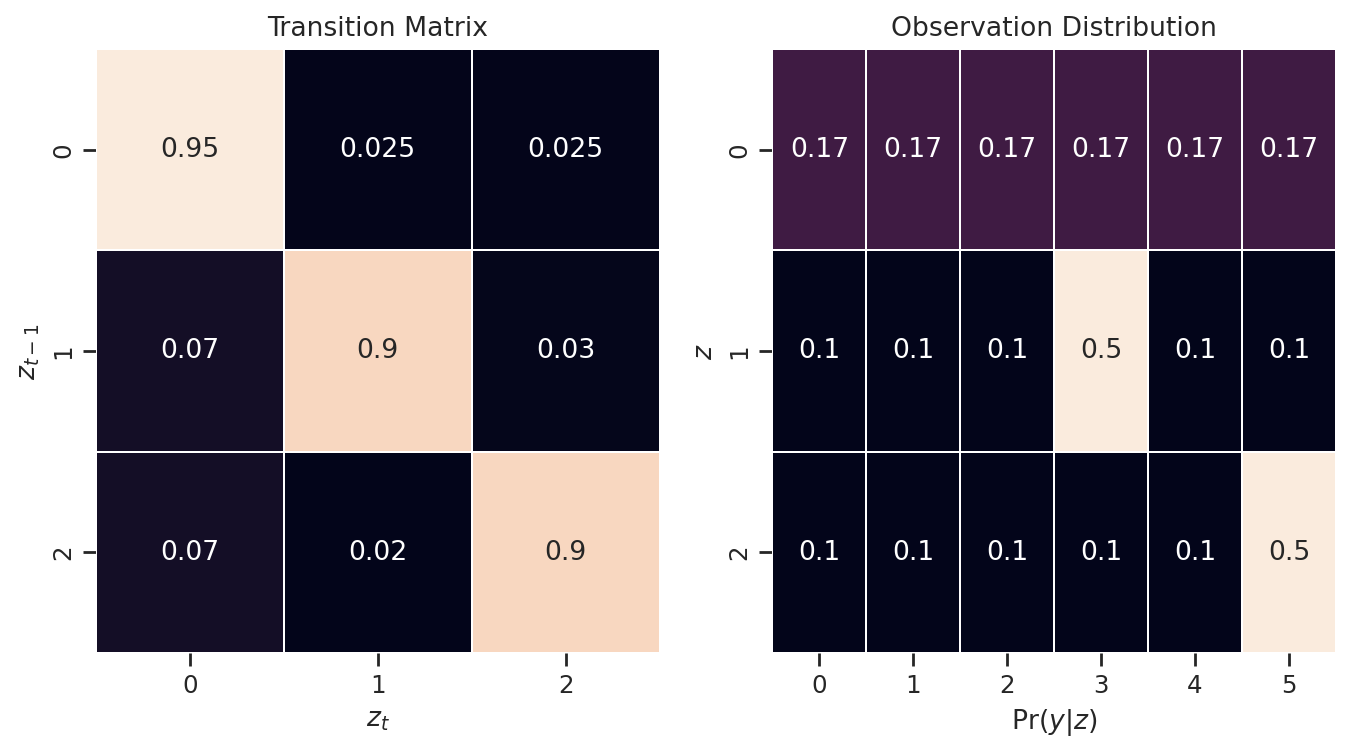

In [8]:
num_states = 3

states_probs_0 = tf.fill([num_states, 1], 1/num_states)

transition_matrix = tf.constant([
    [0.95, 0.025, 0.025], 
    [0.07, 0.9, 0.03],
    [0.07, 0.02, 0.9]
])

emission_params = tf.stack([
    tf.squeeze(tf.constant(tf.fill([1, 6], 1/6))),
    tf.constant([1/10, 1/10, 1/10, 5/10, 1/10, 1/10]),
    tf.constant([*[1/10 for _ in range(5)], 5/10])
    ])

emission_distribution = lambda arg: tfd.Categorical(probs=arg)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(transition_matrix, annot=True, linewidth=.5, ax=axes[0], cbar=False)
sns.heatmap(emission_params, annot=True, linewidth=.5, ax=axes[1], cbar=False)
axes[0].set(xlabel='$z_{t}$', ylabel='$z_{t-1}$', title='Transition Matrix')
axes[1].set(xlabel='$\Pr(y|z)$', ylabel='$z$', title='Observation Distribution')
plt.show()

### Generate Sample Data

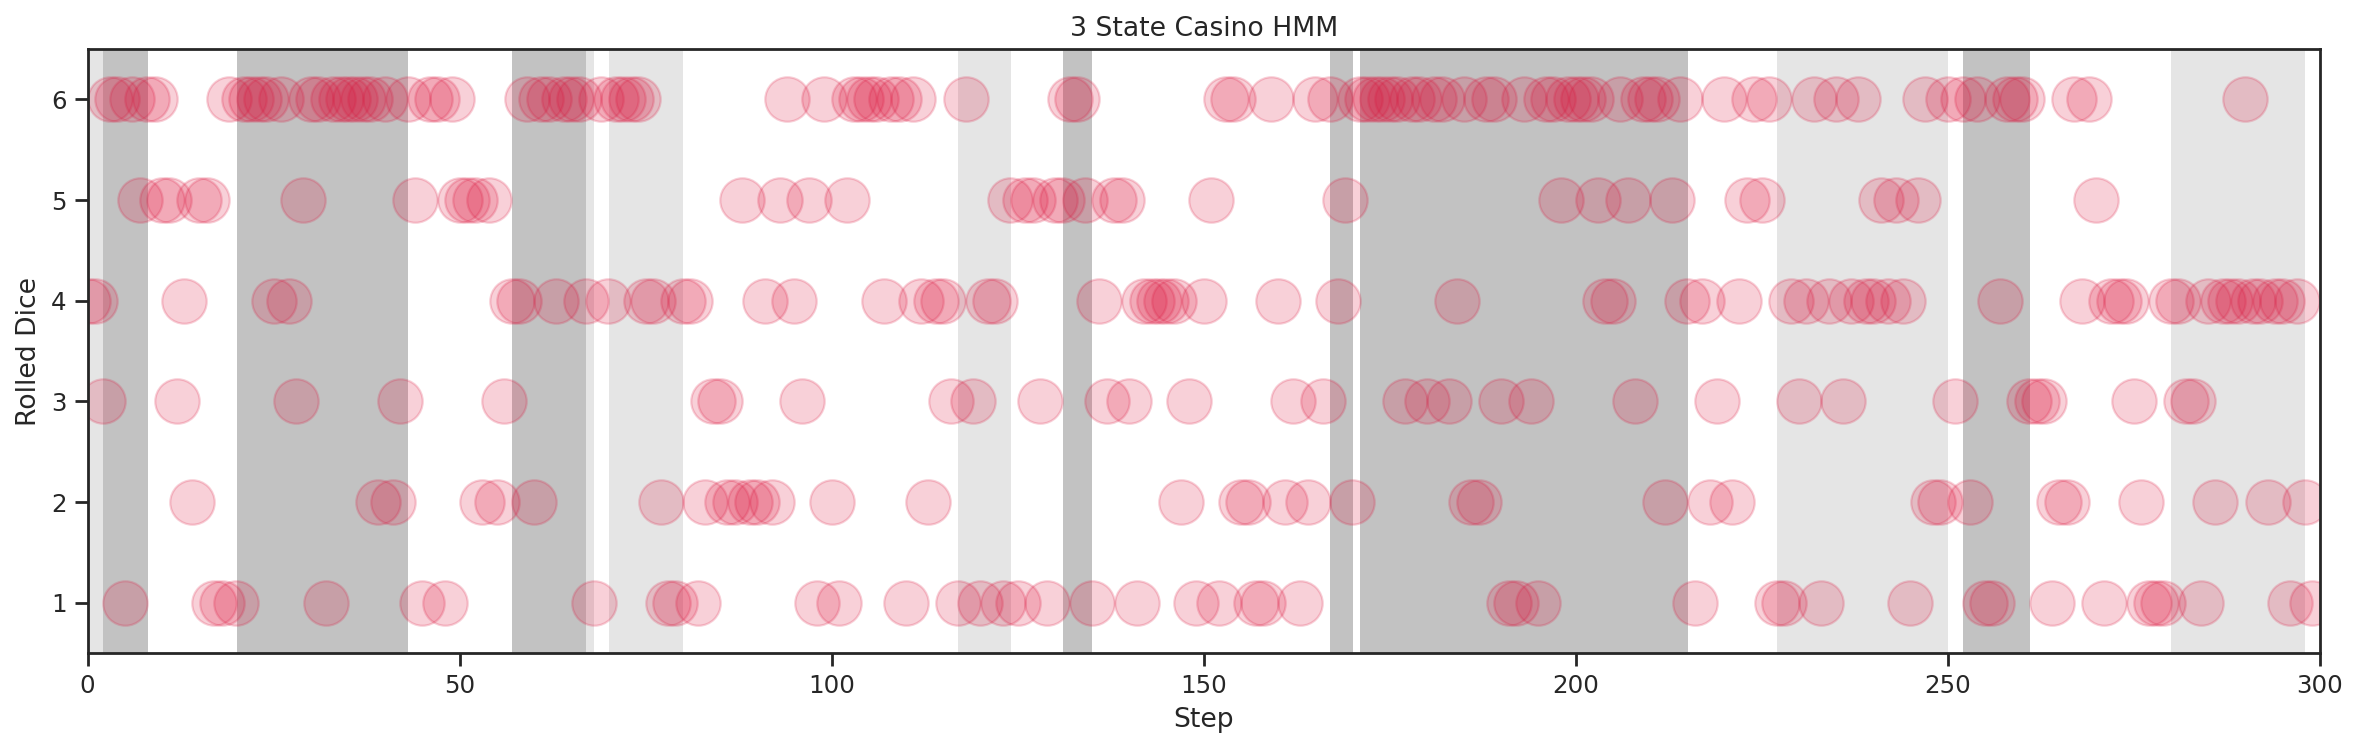

In [10]:
num_batches = 1
num_steps = 300
true_states, observations = HMM_Generator(transition_matrix, emission_distribution, emission_params, states_probs_0, num_steps, num_batches)
plt.figure(figsize=(18, 5))
plt.imshow(true_states[None, 0, :], extent=(0, num_steps, 0, 7), cmap='Greys', alpha=0.24, aspect='auto')
plt.scatter(tf.range(num_steps), observations[0] + 1, color="crimson", alpha=0.2, s=400)
plt.title("{} State Casino HMM".format(num_states)); plt.ylabel('Rolled Dice');  plt.xlabel('Step'); plt.ylim(0.5, 6.5); plt.show()

### Perform State Inference

In [15]:
Inference = HMM_Inference(transition_matrix, emission_distribution, emission_params, states_probs_0, observations)
prob_filtered, Z_filtered= Inference.Forward()
prob_smoothed, β = Inference.Backward(prob_filtered, Z_filtered)
states_Viterbi = Inference.Viterbi()

100%|██████████| 299/299 [00:01<00:00, 222.54it/s]


### Visualizations

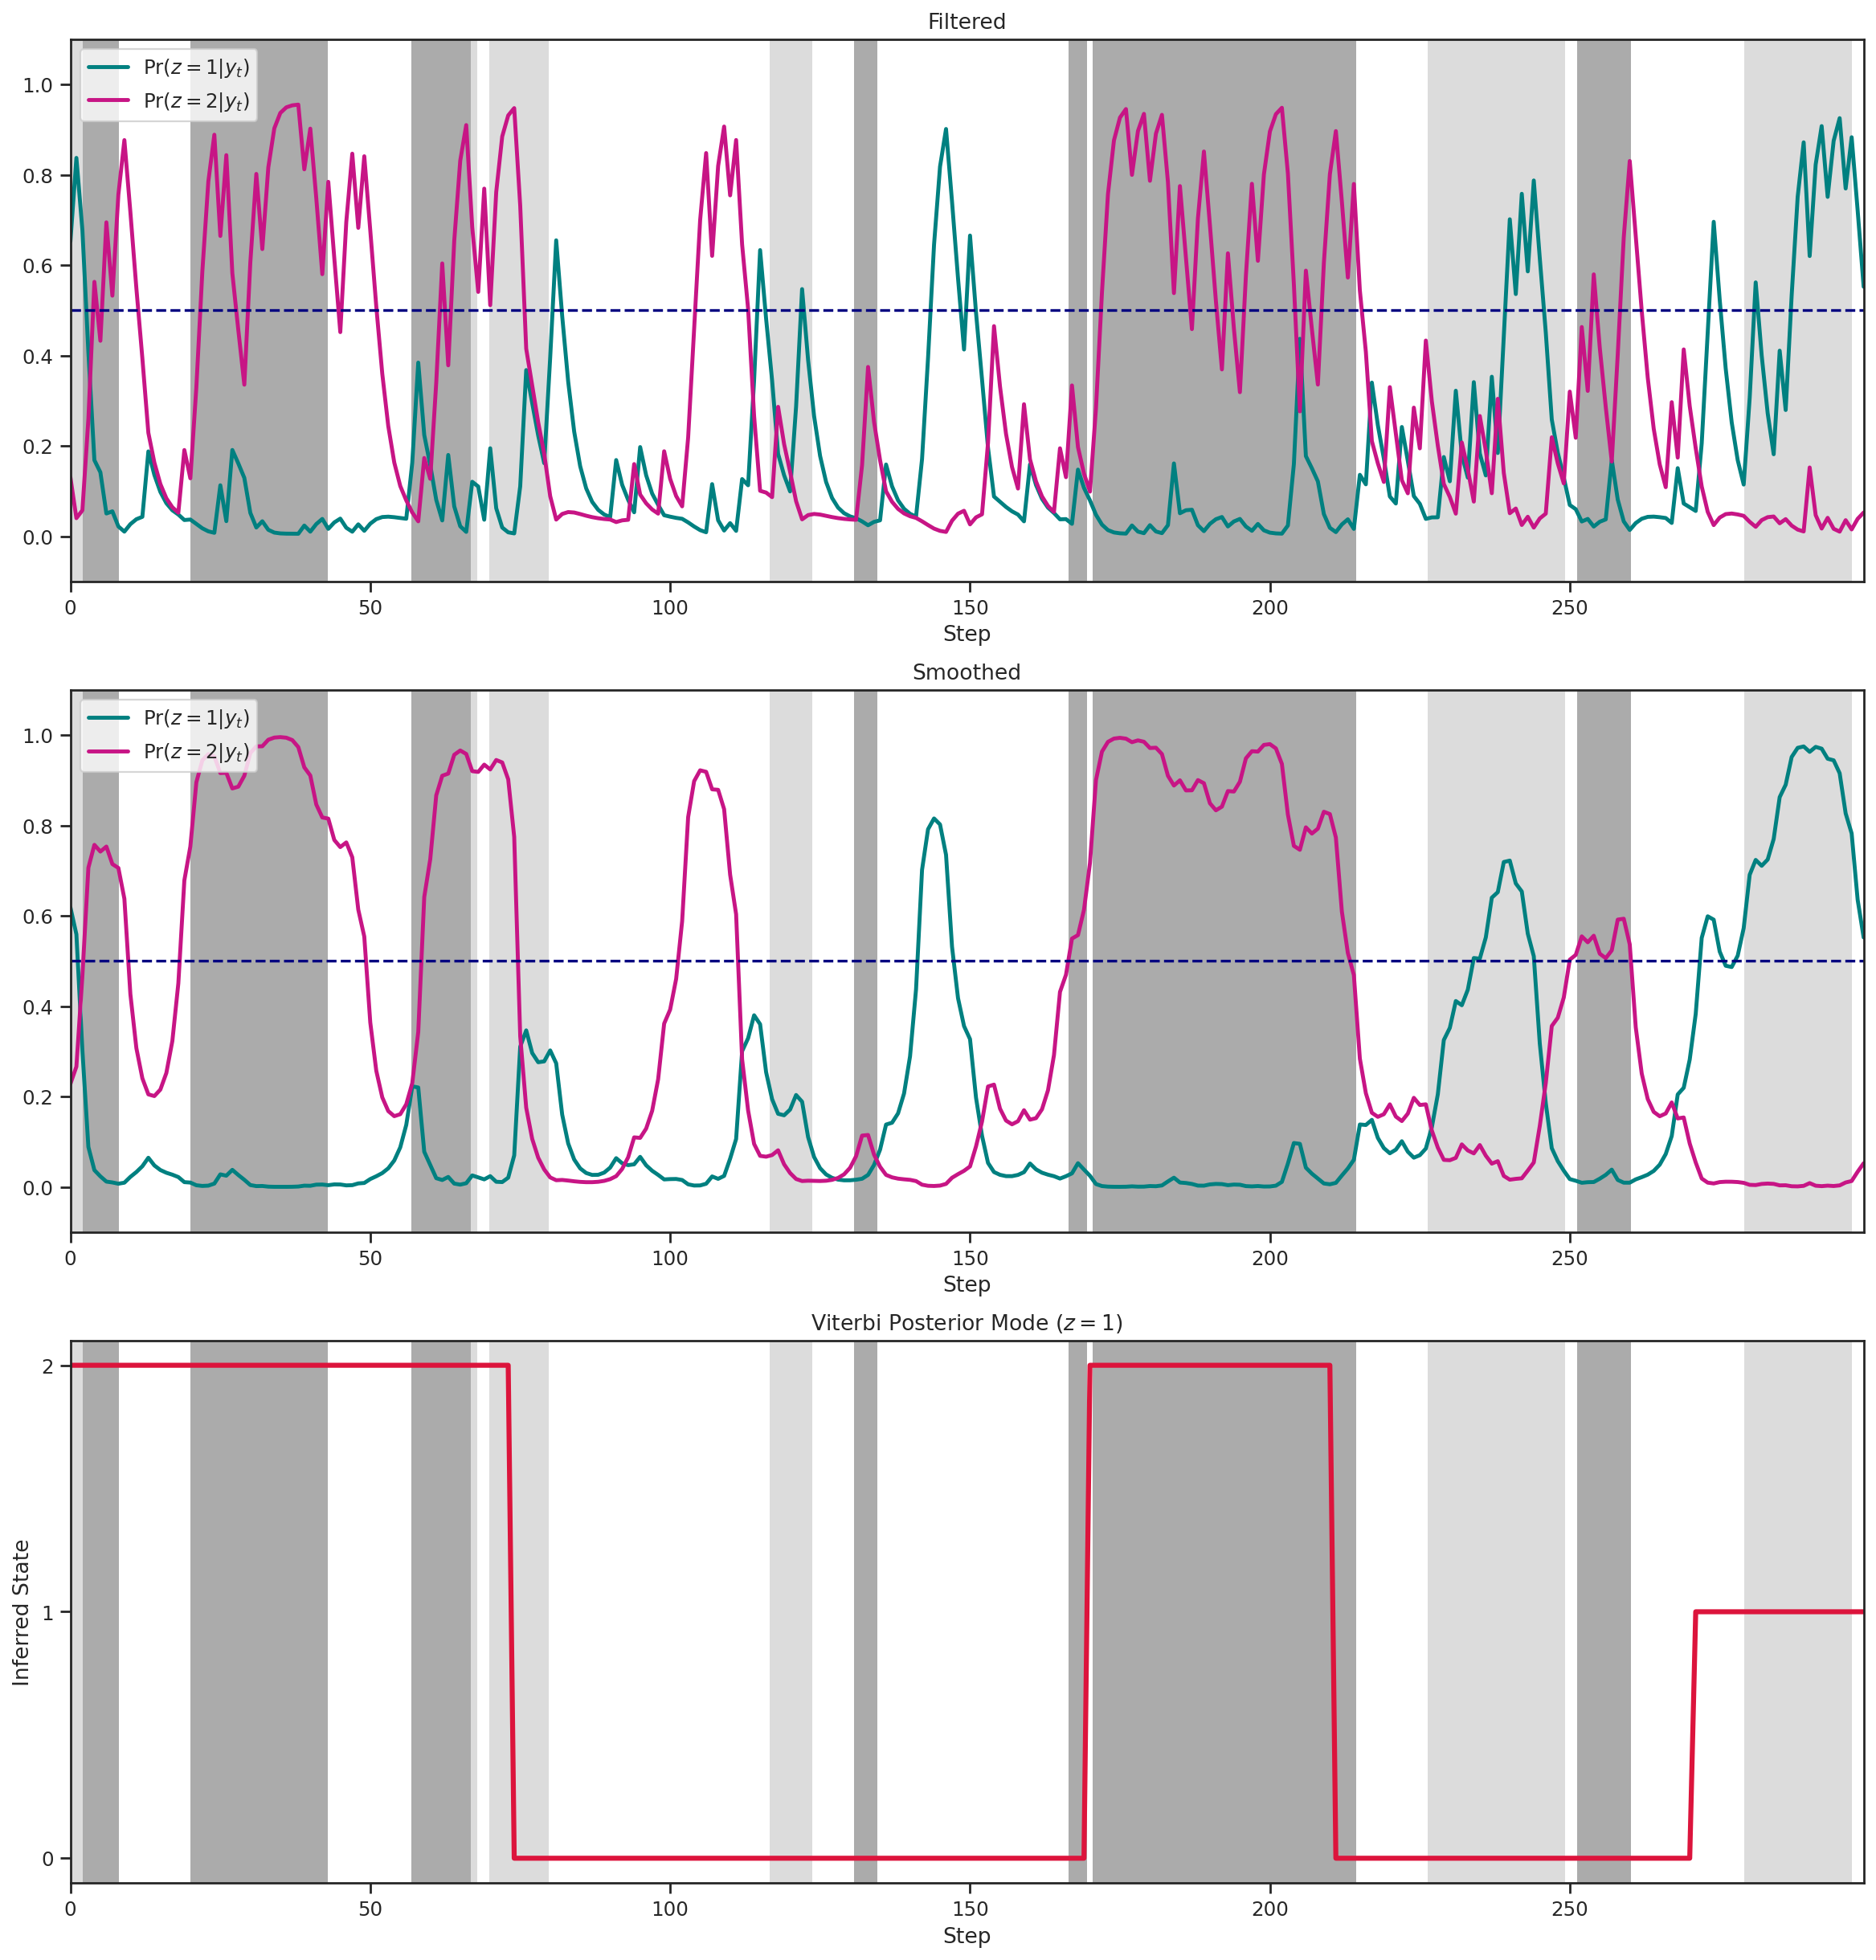

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(18, 19))
title = ['Filtered', 'Smoothed']
data = [prob_filtered[0, :, 1], prob_filtered[0, :, 2], 
        prob_smoothed[0, :, 1], prob_smoothed[0, :, 2]]

for i in range(2):
  axes[i].imshow(true_states[None, 0, :], extent=(0, num_steps - 1, -0.1, 1.1), cmap='Greys', alpha=0.33, aspect='auto')
  axes[i].plot(data[2*i], label='$\Pr(z=1|y_t)$', color='teal', linewidth=2.2)
  axes[i].plot(data[2*i + 1], label='$\Pr(z=2|y_t)$', color='mediumvioletred', linewidth=2.2)
  axes[i].axhline(0.5, color = 'navy', linestyle='--')
  axes[i].set(xlabel='Step', title=title[i])
  axes[i].legend(loc='upper left');

axes[2].plot(states_Viterbi[0, :], color='crimson', linewidth=2.8)
axes[2].imshow(true_states[None, 0, :], extent=(0, num_steps - 1, -0.1, num_states - 0.9), cmap='Greys', alpha=0.33, aspect='auto')
axes[2].set(xlabel='Step', ylabel='Inferred State', title='Viterbi Posterior Mode ($z=1$)', yticks=np.arange(0, 3, 1))

plt.show()

## Example 2. Time Series State Inference

### Set HMM Parameters

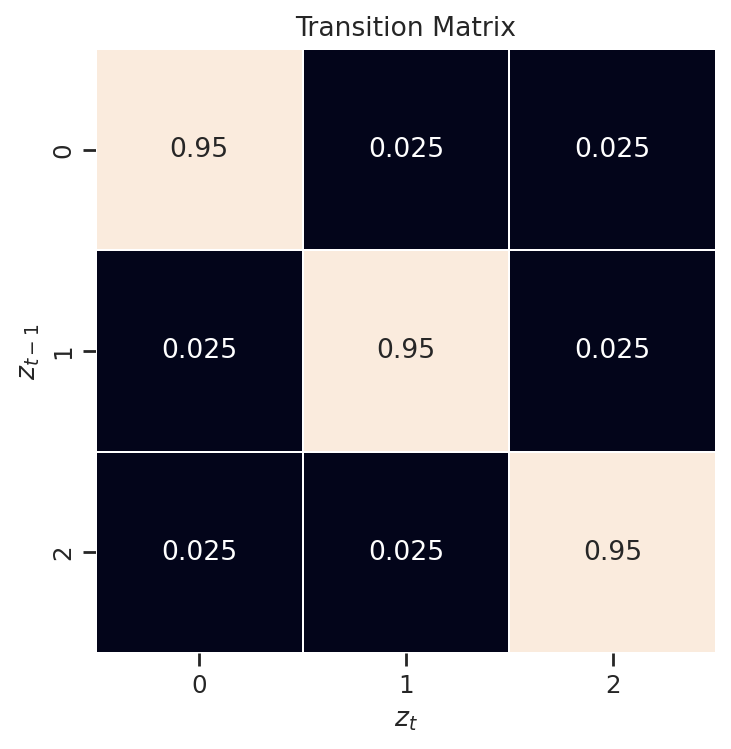

In [30]:
num_states = 3
states_probs_0 = tf.fill([num_states, 1], 1/num_states)

transition_matrix = tf.constant([
    [0.95, 0.025, 0.025], 
    [0.025, 0.95, 0.025],
    [0.025, 0.025, 0.95]
])
emission_params = [
    [1.0, 3.0, 5.0],
    [2.6, 1.2, 0.71]
]

emission_distribution = lambda arg: tfd.Normal(loc=arg[0], scale=arg[1])

fig, axes = plt.subplots(figsize=(5, 5))
sns.heatmap(transition_matrix, annot=True, linewidth=.5, ax=axes, cbar=False)
axes.set(xlabel='$z_{t}$', ylabel='$z_{t-1}$', title='Transition Matrix')
plt.show()

### Generate Sample Time Series

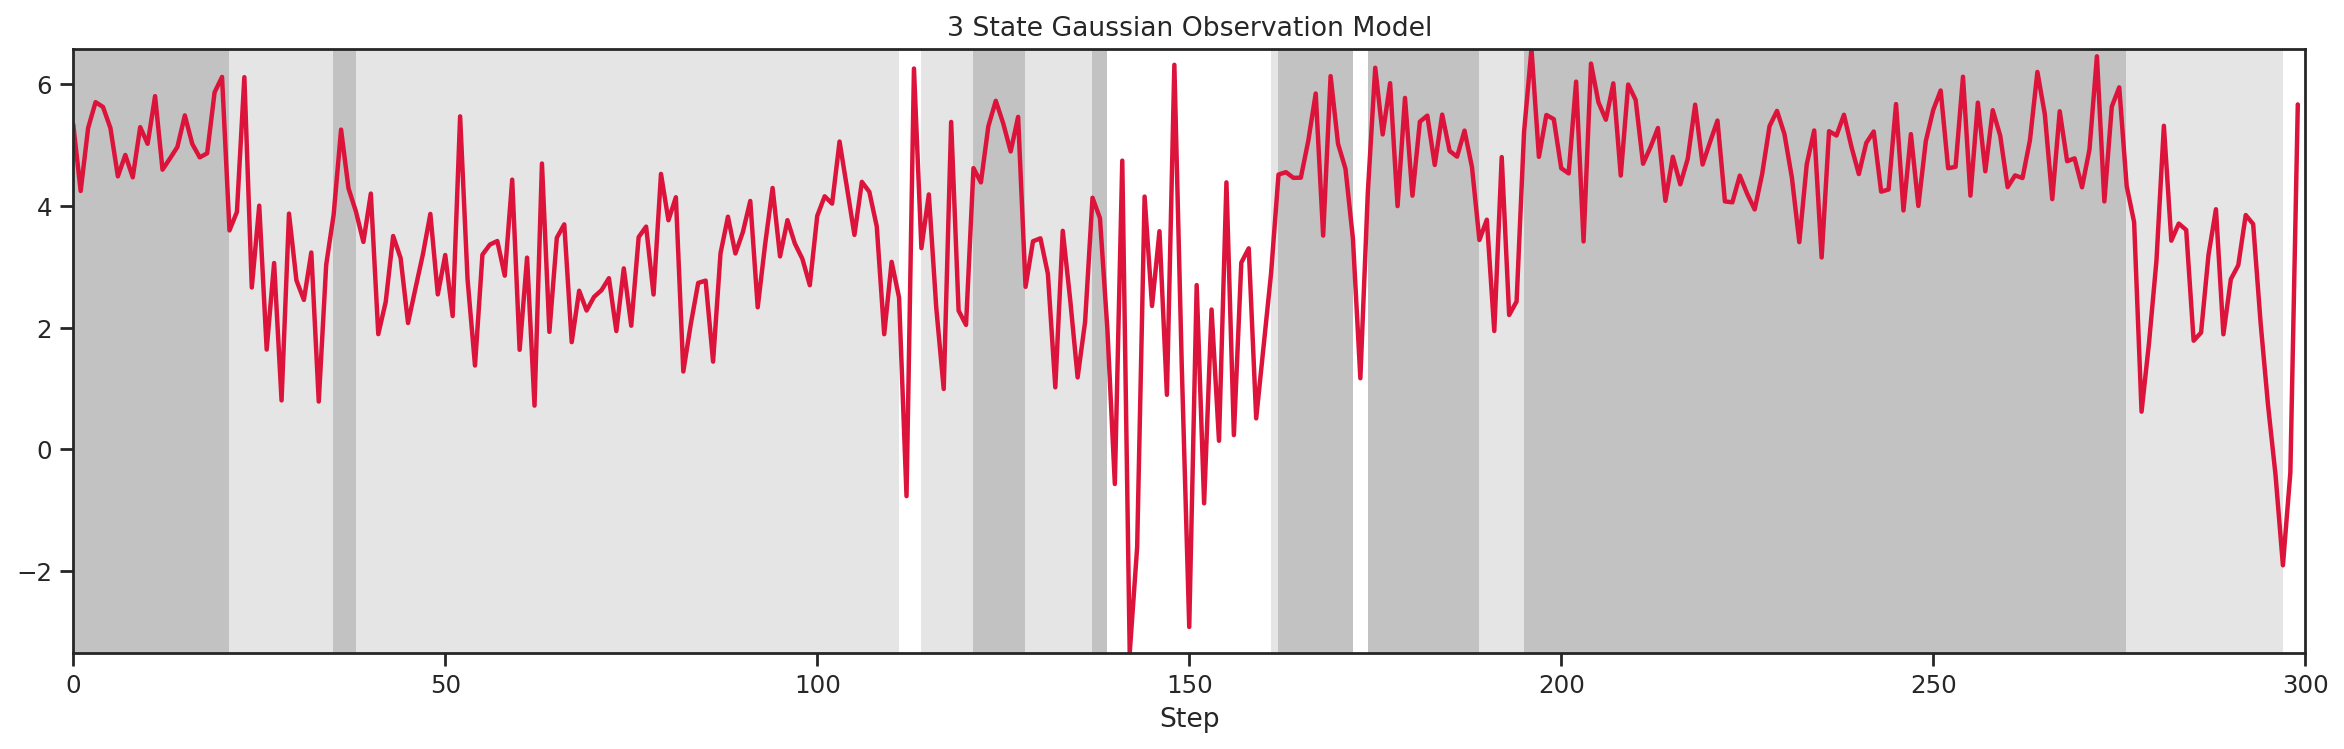

In [39]:
num_batches = 1
num_steps = 300
true_states, observations = HMM_Generator(transition_matrix, emission_distribution, emission_params, states_probs_0, num_steps, num_batches)
plt.figure(figsize=(18, 5))
plt.imshow(true_states[None, 0, :], extent=(0, num_steps, np.min(observations[0]), np.max(observations[0])), cmap='Greys', alpha=0.24, aspect='auto')
plt.plot(observations[0], color="crimson", linewidth=2)
plt.title("{} State Gaussian Observation Model".format(num_states));  plt.xlabel('Step'); plt.show()

### Perform State Inference

In [40]:
Inference = HMM_Inference(transition_matrix, emission_distribution, emission_params, states_probs_0, observations)
prob_filtered, Z_filtered= Inference.Forward()
prob_smoothed, β = Inference.Backward(prob_filtered, Z_filtered)
states_Viterbi = Inference.Viterbi()

100%|██████████| 299/299 [00:01<00:00, 150.16it/s]


### Vizualizations

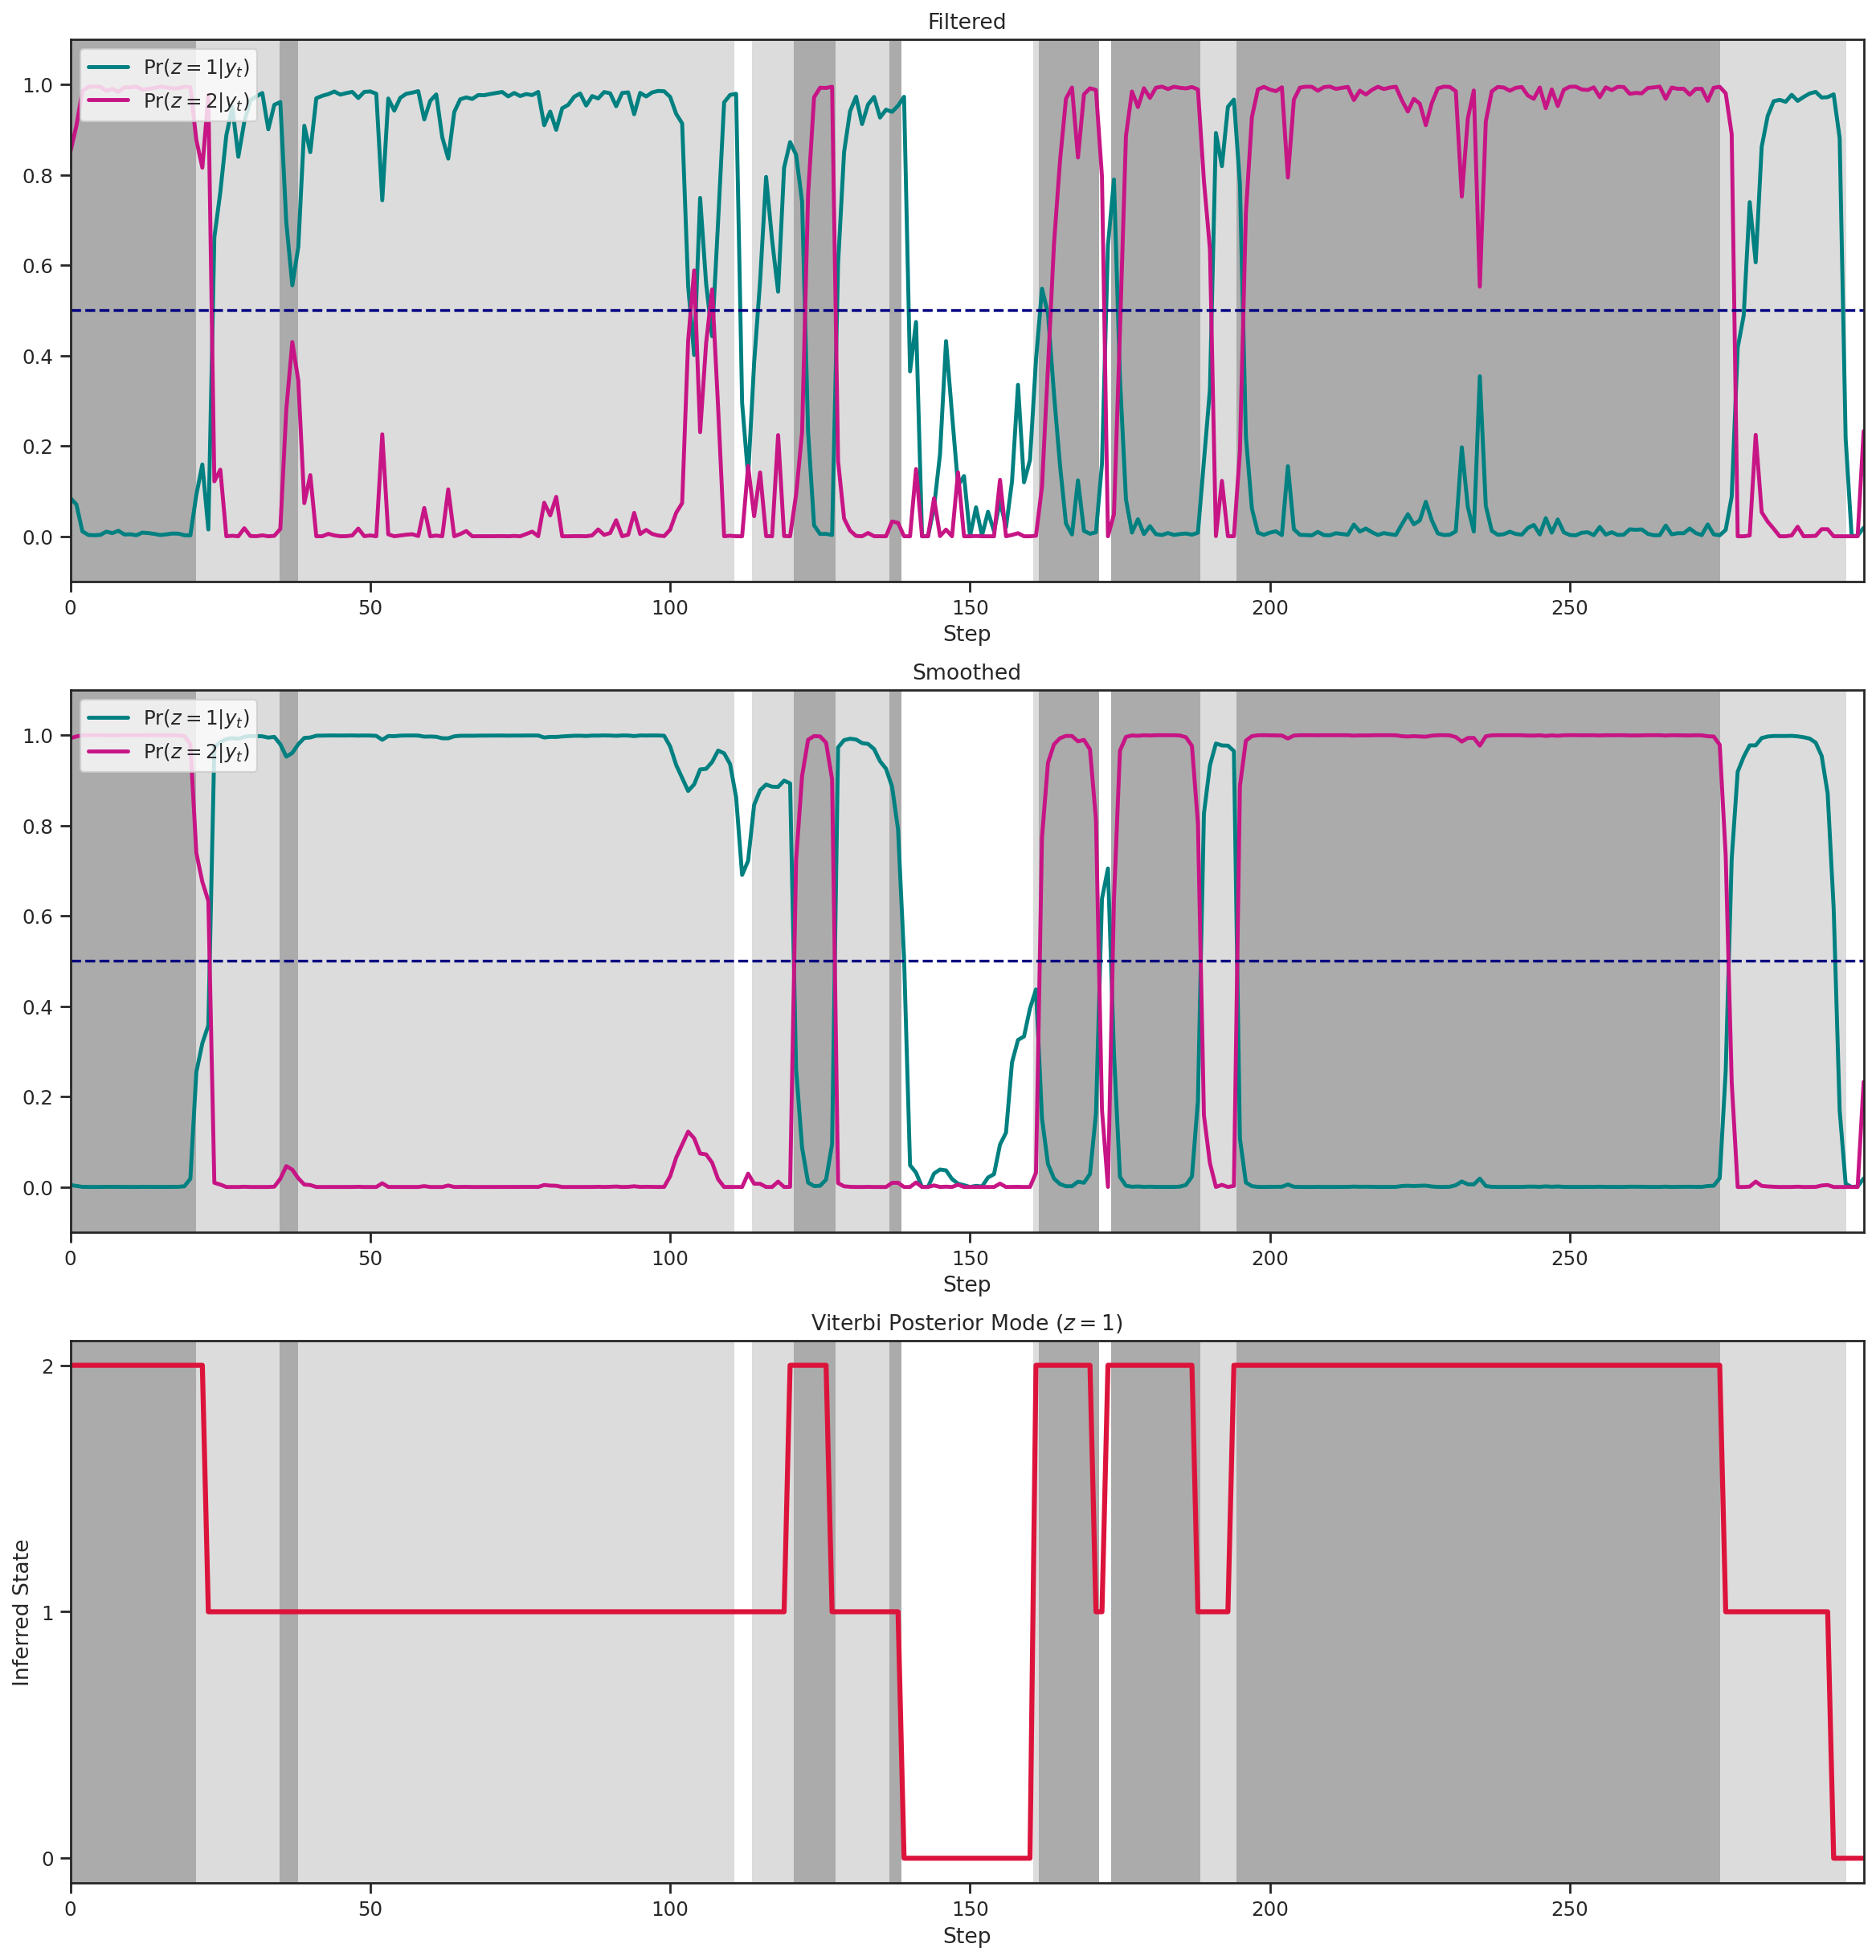

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(18, 19))
title = ['Filtered', 'Smoothed']
data = [prob_filtered[0, :, 1], prob_filtered[0, :, 2], 
        prob_smoothed[0, :, 1], prob_smoothed[0, :, 2]]

for i in range(2):
  axes[i].imshow(true_states[None, 0, :], extent=(0, num_steps - 1, -0.1, 1.1), cmap='Greys', alpha=0.33, aspect='auto')
  axes[i].plot(data[2*i], label='$\Pr(z=1|y_t)$', color='teal', linewidth=2.2)
  axes[i].plot(data[2*i + 1], label='$\Pr(z=2|y_t)$', color='mediumvioletred', linewidth=2.2)
  axes[i].axhline(0.5, color = 'navy', linestyle='--')
  axes[i].set(xlabel='Step', title=title[i])
  axes[i].legend(loc='upper left');

axes[2].plot(states_Viterbi[0, :], color='crimson', linewidth=2.8)
axes[2].imshow(true_states[None, 0, :], extent=(0, num_steps - 1, -0.1, num_states - 0.9), cmap='Greys', alpha=0.33, aspect='auto')
axes[2].set(xlabel='Step', ylabel='Inferred State', title='Viterbi Posterior Mode ($z=1$)', yticks=np.arange(0, 3, 1))
plt.show()

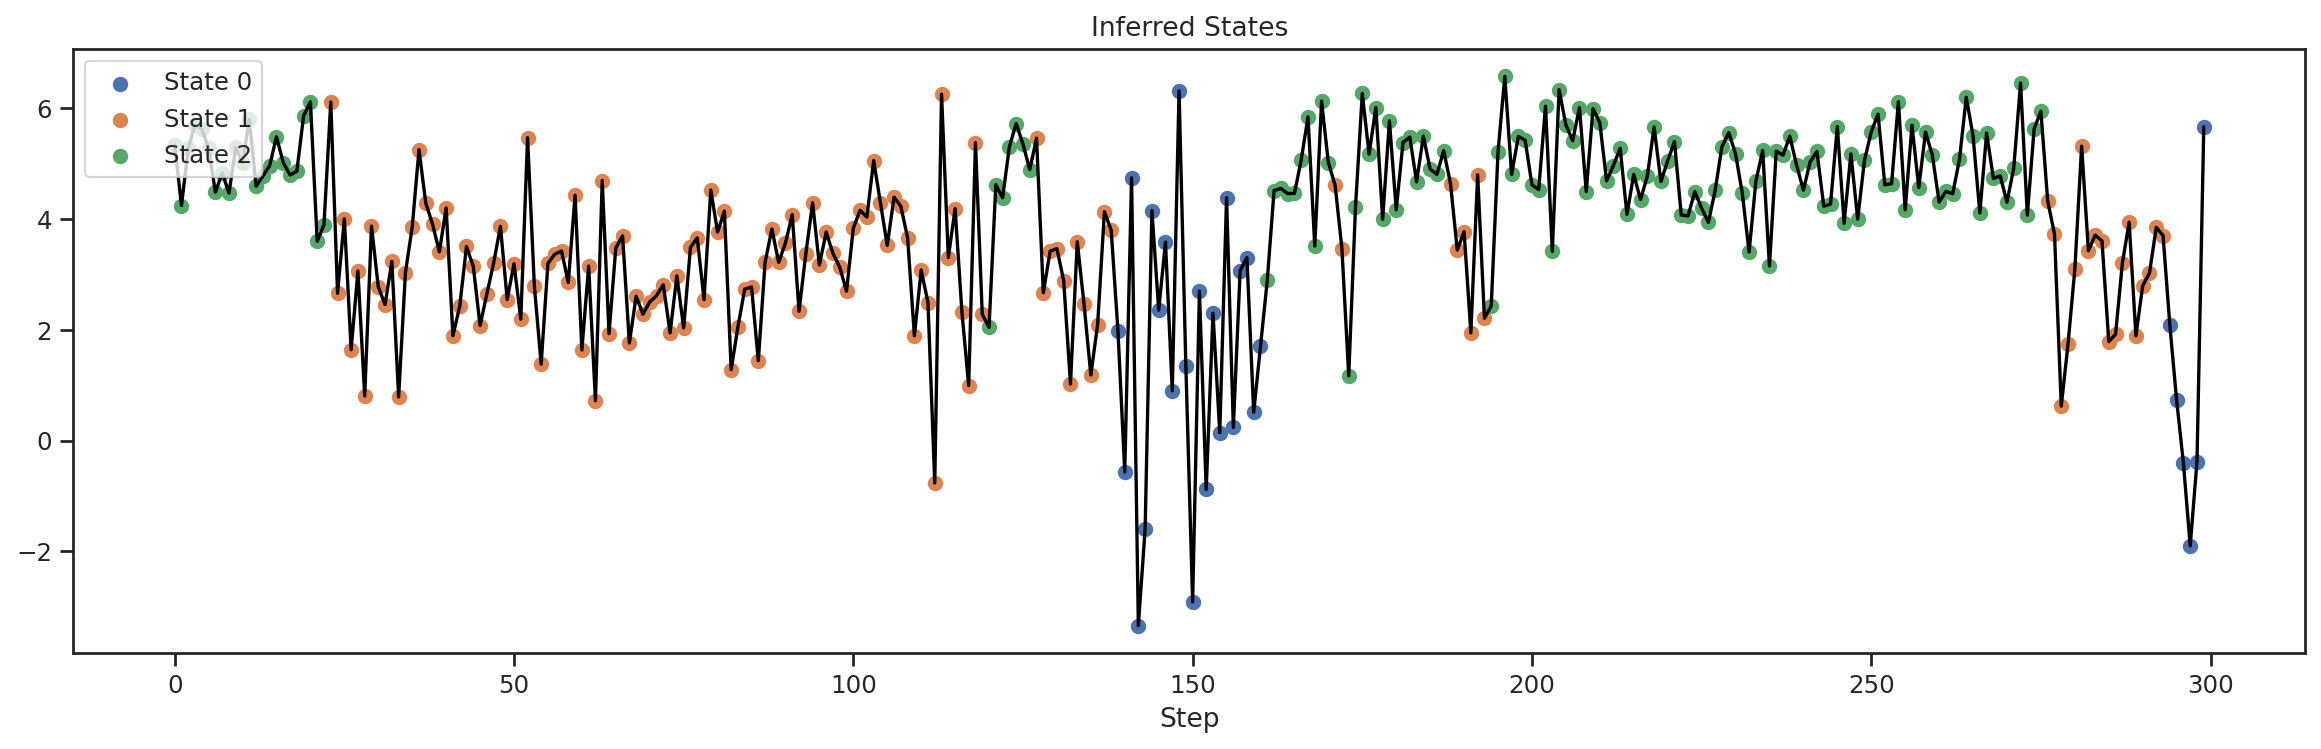

In [44]:
plt.figure(figsize=(18, 5))
plt.plot(observations[0], color="black", linewidth=1.5)
plt.title("Inferred States");  plt.xlabel('Step')
for state in range(3):
  index = tf.where(states_Viterbi[0] == state)
  obs = tf.gather_nd(observations[0], index)
  plt.scatter(index, obs, s=35, label='State {}'.format(state))
  plt.legend(loc='upper left');
plt.show()